In [2]:
import numpy as np
import torch
import torchvision

In [4]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2) # window_size=2, stride=2 
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1, padding=1) 
        self.conv1_ = nn.Conv2d(32, 64, 3, stride=1, padding=1)         
        self.conv1__ = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv2_ = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(512*2*2, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        
        self.drop_layer = nn.Dropout(0.2)

        
        # input: 3x32x32
        # after conv1: 32,3x3,p=1 -> 32x32x32
        # after conv1_: 64,3x3,p=1 -> 64x32x32
        # after conv1__: 64,3x3,p=1 -> 64x32x32
        # after pooling: 64x16x16
        # after conv2: 128,3x3,p=1 -> 128x16x16
        # after conv2_: 128,3x3,p=1 -> 128x16x16
        # after pooling: 128x8x8
        # after conv3: 256,3x3,p=1 -> 256x8x8
        # after pooling: 256x4x4
        # after conv4: 512,3x3,p=1 -> 512x4x4
        # after pooling: 512x2x2
        # review
        # fully connecteds...
    
    # Without dropout
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv1_(x))
        x = self.pool(F.relu(self.conv1__(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv2_(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu((self.conv4(x))))
        x = x.view(-1, 512*2*2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
    # With dropout
#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv1_(x))
#         x = self.pool(F.relu(self.conv1__(x)))
#         x = self.drop_layer(x)
#         x = F.relu(self.conv2(x))
#         x = self.pool(F.relu(self.conv2_(x)))
#         x = self.drop_layer(x)
#         x = self.pool(F.relu(self.conv3(x)))
#         x = self.drop_layer(x)
#         x = self.pool(F.relu((self.conv4(x))))
#         x = self.drop_layer(x)
#         x = x.view(-1, 512*2*2)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


net = Net()

net.to(device)
for name, param in net.named_parameters():
    if param.device.type != 'cuda':
        print('param {}, not on GPU'.format(name))

net.train(True)

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1__): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (drop_layer): Dropout(p=0.2, inplace=False)
)

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.99)

In [8]:
def eval(data_l):
    correct = 0
    total = 0
    with torch.no_grad():
        running_loss = 0.0
        for i, data in enumerate(data_l, 0):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss_ = criterion(outputs, labels)
            running_loss += loss_.item()
    return [running_loss/i, 100 * correct / total]

In [ ]:
eval(testloader)

In [ ]:
train_logs = {'train_accuracy': [], 'validation_accuracy': [], 'train_loss': [], 'validation_loss': []}


for epoch in range(80):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        for state in optimizer.state.values():
            for k, v in state.items():
                if torch.is_tensor(v):
                    state[k] = v.cuda()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
#         if i % verbose_len == verbose_len-1:    # print every 1000 mini-batches
#             print(f"epoch:{epoch + 1}, batch:{i + 1} loss:{running_loss / verbose_len}")
#             running_loss = 0.0

    net.eval()        
    train_loss, train_accuracy = eval(trainloader)
    valid_loss, valid_accuracy = eval(testloader)
    net.train(True)
    
    print(f"epoch:{epoch + 1} training_loss:{train_loss}, training_accuracy:{train_accuracy}")
    print(f"epoch:{epoch + 1} validation_loss:{valid_loss}, validation_accuracy:{valid_accuracy}")
    
    train_logs['train_accuracy'].append(train_accuracy)
    train_logs['validation_accuracy'].append(valid_accuracy)
    train_logs['train_loss'].append(train_loss)
    train_logs['validation_loss'].append(valid_loss)

print('Finished Training')

epoch:1 training_loss:2.304718665826336, training_accuracy:10.0
epoch:1 validation_loss:2.310650039941837, validation_accuracy:10.0
epoch:2 training_loss:2.302141488132648, training_accuracy:11.682
epoch:2 validation_loss:2.3079631343866005, validation_accuracy:11.47
epoch:3 training_loss:1.7792006715769653, training_accuracy:33.818
epoch:3 validation_loss:1.7757669415993569, validation_accuracy:34.72
epoch:4 training_loss:1.5518146532751076, training_accuracy:43.676
epoch:4 validation_loss:1.5576716267909758, validation_accuracy:43.42
epoch:5 training_loss:1.2755672371494327, training_accuracy:53.996
epoch:5 validation_loss:1.2976608719581213, validation_accuracy:52.99
epoch:6 training_loss:1.036075000993421, training_accuracy:62.5
epoch:6 validation_loss:1.111013767046806, validation_accuracy:60.03
epoch:7 training_loss:0.8619908708578188, training_accuracy:69.146
epoch:7 validation_loss:0.9785959525750234, validation_accuracy:65.18
epoch:8 training_loss:0.6659465544355053, training_

In [ ]:
import pickle
with open('logs_my_model_dropout.pickle','wb') as f:
    pickle.dump(train_logs, f)

In [ ]:
import pickle
with open('CNN_model_dropout.pickle','wb') as f:
    pickle.dump(net, f)

In [ ]:
# saved_logs = train_logs
saved_logs_1 = train_logs

In [ ]:
all_logs = saved_logs_1

# Plotting train vs. validation "accuracy" for all
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

epochs = 20
plt.plot(np.arange(epochs), all_logs['train_accuracy'], label='train', linestyle='dashed', color='red')
plt.plot(np.arange(epochs), all_logs['validation_accuracy'], label='validation', color='blue')

plt.xlabel('epochs')
plt.ylabel('accuracy')
# plt.legend()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(np.arange(epochs), all_logs['train_loss'], label='train', linestyle='dashed', color='red')
plt.plot(np.arange(epochs), all_logs['validation_loss'], label='validation', color='blue')

plt.xlabel('epochs')
plt.ylabel('loss')
# plt.legend()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [ ]:
# This works with lr=0.001

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1) # 16x16x32
        self.pool = nn.MaxPool2d(2, 2) # window_size=2, stride=2
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

    
    def forward(self, x):
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu((self.conv3(x))))
        x = x.view(-1, 128)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        x = self.fc3(x)
        return x

net = Net()

# self.fc2 = nn.Linear(2048, 1024)
# self.fc3 = nn.Linear(1024, 512)
# self.fc4 = nn.Linear(512, 256)
# self.fc5 = nn.Linear(256, 10)

net.to(device)
for name, param in net.named_parameters():
    if param.device.type != 'cuda':
        print('param {}, not on GPU'.format(name))

net.train(True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.pool = nn.MaxPool2d(2, 2) # window_size=2, stride=2 
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1) 
        self.conv1_ = nn.Conv2d(64, 64, 3, stride=1, padding=1)         
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv2_ = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv3_ = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        
        self.drop_layer = nn.Dropout(0.3)

        
#         self.bn1 = nn.BatchNorm2d(64)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.bn3 = nn.BatchNorm2d(128)

        # input: 3x32x32
        # after conv1: 32x32x32
        # after pooling: 32x16x16
        # after conv2: 64x14x14
        # after conv3: 128x10x10
        # after pooling: 128x5x5
        # after conv4: 512x1x1
        # review
        # fully connecteds...
        
        # input: 3x32x32
        # after conv1: 64,3x3,p=1 -> 64x32x32
        # after conv1 again: 64,3x3,p=1 -> 64x32x32
        # after pooling: 64x16x16
        # after conv2: 128,3x3,p=1 -> 128x16x16
        # after conv2 again: 128,3x3,p=1 -> 128x16x16
        # after pooling: 128x8x8
        # after conv3: 256,3x3,p=1 -> 256x8x8
        # after conv3 again: 256,3x3,p=1 -> 256x8x8
        # after pooling: 256x4x4
        # after conv4: 512,3x3,p=1 -> 512x4x4
        # after conv4 again: 512,3x3,p=1 -> 512x4x4
        # after pooling: 512x2x2
        # after conv5: 512,3x3,p=1 -> 512x2x2
        # after conv5 again: 512,3x3,p=1 -> 512x2x2
        # after pooling: 512x1x1
        # review
        # fully connecteds...
    
    def forward(self, x):
        x = self.drop_layer(F.relu(self.conv1(x)))
#         F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv1_(x)))
        x = self.drop_layer(F.relu(self.conv2(x)))
#         x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv2_(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv3_(x)))
        x = F.relu((self.conv4(x)))
        x = self.pool(F.relu((self.conv5(x))))
        x = F.relu((self.conv5(x)))
        x = self.pool(F.relu((self.conv5(x))))
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 5 * 5)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


net = Net()

# self.fc2 = nn.Linear(2048, 1024)
# self.fc3 = nn.Linear(1024, 512)
# self.fc4 = nn.Linear(512, 256)
# self.fc5 = nn.Linear(256, 10)

net.to(device)
for name, param in net.named_parameters():
    if param.device.type != 'cuda':
        print('param {}, not on GPU'.format(name))

net.train(True)

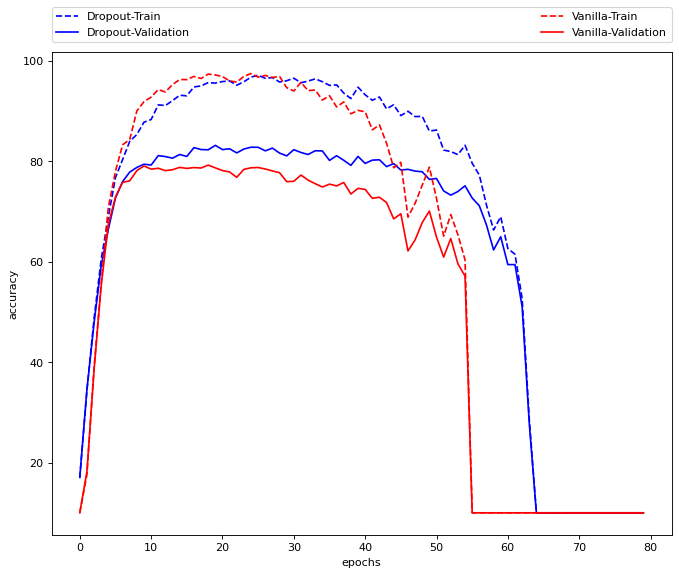

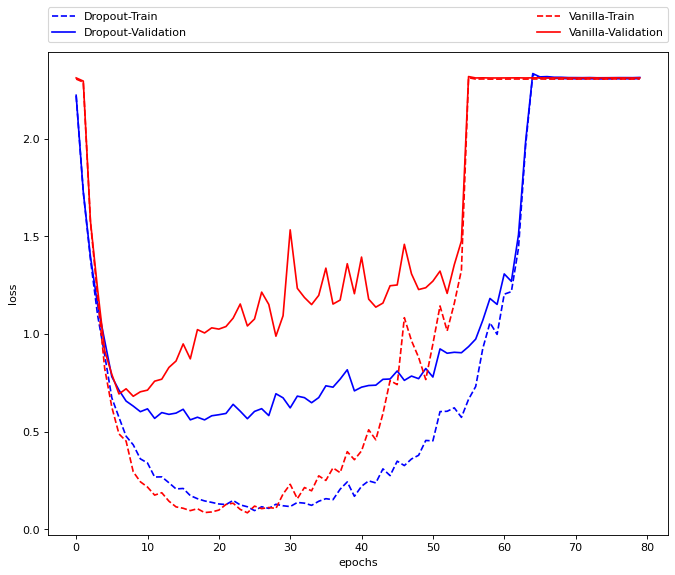

In [3]:
import pickle
with open('logs_dropout_80_epoch.pickle','rb') as f:
    dropout_80_logs = pickle.load(f)

with open('logs_vanilla_80_epoch.pickle','rb') as f:
    vanilla_80_logs = pickle.load(f)

# Plotting train vs. validation "accuracy" for all
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

epochs = 80
plt.plot(np.arange(epochs), dropout_80_logs['train_accuracy'], label='Dropout-Train', linestyle='dashed', color='blue')
plt.plot(np.arange(epochs), dropout_80_logs['validation_accuracy'], label='Dropout-Validation', color='blue')

plt.plot(np.arange(epochs), vanilla_80_logs['train_accuracy'], label='Vanilla-Train', linestyle='dashed', color='red')
plt.plot(np.arange(epochs), vanilla_80_logs['validation_accuracy'], label='Vanilla-Validation', color='red')

plt.xlabel('epochs')
plt.ylabel('accuracy')
# plt.legend()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(np.arange(epochs), dropout_80_logs['train_loss'], label='Dropout-Train', linestyle='dashed', color='blue')
plt.plot(np.arange(epochs), dropout_80_logs['validation_loss'], label='Dropout-Validation', color='blue')

plt.plot(np.arange(epochs), vanilla_80_logs['train_loss'], label='Vanilla-Train', linestyle='dashed', color='red')
plt.plot(np.arange(epochs), vanilla_80_logs['validation_loss'], label='Vanilla-Validation', color='red')

plt.xlabel('epochs')
plt.ylabel('loss')
# plt.legend()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()


In [ ]:
with open('../q4-approx-grad/relu-4h/logs_glorot_relu_4h.pickle','rb') as f:
    mlp_best_20_logs = pickle.load(f)

with open('logs_my_model.pickle','rb') as f:
    cnn_20_logs = pickle.load(f)

In [ ]:
print(100*np.array(mlp_best_20_logs['train_accuracy']))

In [ ]:
# Plotting train vs. validation "accuracy" for all
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

epochs = 20
plt.plot(np.arange(epochs), 100*np.array(mlp_best_20_logs['train_accuracy']), label='MLP-Train', linestyle='dashed', color='blue')
plt.plot(np.arange(epochs), 100*np.array(mlp_best_20_logs['validation_accuracy']), label='MLP-Validation', color='blue')

plt.plot(np.arange(epochs), cnn_20_logs['train_accuracy'], label='Vanilla-CNN-Train', linestyle='dashed', color='red')
plt.plot(np.arange(epochs), cnn_20_logs['validation_accuracy'], label='Vanilla-CNN-Validation', color='red')

plt.xlabel('epochs')
plt.ylabel('accuracy')
# plt.legend()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(np.arange(epochs), mlp_best_20_logs['train_loss'], label='MLP-Train', linestyle='dashed', color='blue')
plt.plot(np.arange(epochs), mlp_best_20_logs['validation_loss'], label='MLP-Validation', color='blue')

plt.plot(np.arange(epochs), cnn_20_logs['train_loss'], label='Vanilla-CNN-Train', linestyle='dashed', color='red')
plt.plot(np.arange(epochs), cnn_20_logs['validation_loss'], label='Vanilla-CNN-Validation', color='red')

plt.xlabel('epochs')
plt.ylabel('loss')
# plt.legend()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()
